
*   Step 1: Load Dataset
*   Step 2: Make Dataset Iterable
*   Step 3: Create Model Class
*   Step 4: Instantiate Model Class
*   Step 5: Instantiate Loss Class
*   Step 6: Instantiate Optimizer Class
*   Step 7: Train Model


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

print('setup complete')

setup complete


In [ ]:
#switch to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
#helper function which we will use lateron to plot after classifying 

def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [ ]:
#custom transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

#Download and load the training data and testing data
train_data = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
test_data    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)

#Define the trianloader and testloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

trainloader

In [ ]:
print(len(train_data), len(test_data))

60000 10000


labels of this image is:  tensor([1, 0, 6, 9, 5, 7, 6, 4, 2, 2, 5, 8, 9, 4, 7, 0, 6, 0, 0, 7, 8, 9, 2, 5,
        0, 9, 5, 4, 5, 0, 1, 2])


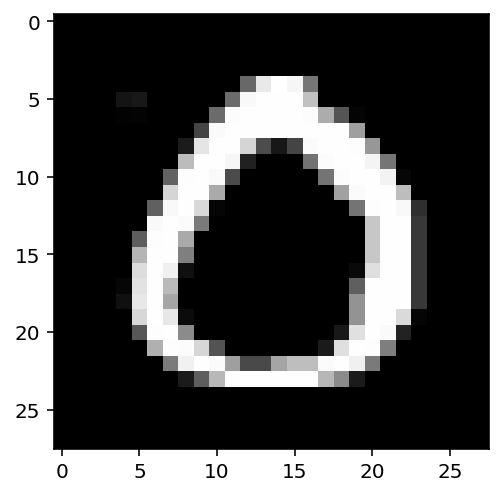

In [ ]:
#show a sample image
dataiter = iter(trainloader)
images, labels = dataiter.next()
# image, label = next(iter(test_data))
# plt.imshow(image.squeeze(), cmap="gray")
print('labels of this image is: ', labels)

plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

# image,label=test_data[0]
# print(image.shape)

#output shape is 1 which means its a grayscale

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

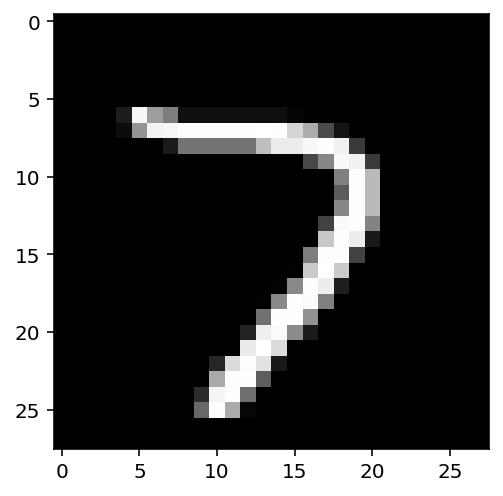

In [ ]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [ ]:
#alternative code to show images but a grid of them
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

def print_sample_digit(index):
    print(str.format('Label: {}',labels[index]))
    plt.figure(num=None, figsize=(1, 1), dpi=56, facecolor='w', edgecolor='k')
    plt.imshow(images[index].numpy().squeeze(), cmap='Greys_r');

labels

In [ ]:
len(labels) #loads the labels per batch

In [ ]:
# for i in range(0, len(labels)):
#   print_sample_digit(i)

In [ ]:
# class FeedforwardNeuralNetModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(FeedforwardNeuralNetModel, self).__init__()
#         # Linear function
#         self.fc1 = nn.Linear(input_dim, hidden_dim) 
#         # Non-linearity
#         self.relu = nn.ReLU()
#         # Linear function (readout)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)  

#     def forward(self, x):
#         # Linear function
#         out = self.fc1(x)
#         # Non-linearity
#         out = self.relu(out)
#         # Linear function (readout)
#         out = self.fc2(out)
#         return out

In [ ]:

# Class with sequential API

class Net(nn.Module):
    
    def __init__(self):

      super(Net, self).__init__()
      
      #first conv layer
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
      self.relu1 = nn.ReLU()
      # Max pool 1
      self.maxpool1 = nn.MaxPool2d(kernel_size=2)

      # Convolution 2
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
      self.relu2 = nn.ReLU()

      # Max pool 2
      self.maxpool2 = nn.MaxPool2d(kernel_size=2)

      # Fully connected 1 (readout)
      self.fc1 = nn.Linear(32 * 4 * 4, 10)


    def forward(self, x):
      # Convolution 1
      out = self.conv1(x)
      out = self.relu1(out)
      # Max pool 1
      out = self.maxpool1(out)

      # Convolution 2 
      out = self.conv2(out)
      out = self.relu2(out)
      # Max pool 2 
      out = self.maxpool2(out)

      # Resize
      out = out.view(out.size(0), -1)

      # Linear function (readout)
      out = self.fc1(out)
      out = F.softmax(out, dim=1)

      return out

In [ ]:
model = Net()
model

In [ ]:
#define the optimizer and the loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, 'max', factor = 0.5, verbose=True)
criterion = nn.NLLLoss()


In [ ]:
epochs = 3
print_every = 40

train_loss = []
val_loss = []
#torch.autograd.set_detect_anomaly(True)

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        #images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
    train_loss.append(running_loss/images.shape[0])

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):
            #images, labels = data
            # calculate outputs by running images through the network
            #images = images.resize_(images.size()[0],  784)
            outputs = model(images)
            v_loss = criterion(outputs, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_loss.append(v_loss/images.shape[0])

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))